In [209]:
import pandas as pd
import numpy as np
import json

# plotting
import matplotlib.pyplot as plt

# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

#opening data
import os
import pathlib
import warnings
from joblib import load

# modelling
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#used for plots
from itertools import combinations_with_replacement
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d
from scipy import stats
from mplsoccer import PyPizza, FontManager

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [271]:
#load data - store it in train dataframe
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', 'events_Italy.json') # delete
with open(path) as f: # delete #
    data = json.load(f) # delete #
train = pd.DataFrame(data) # delete #
    
#potential data collection error handling
train = train.loc[train.apply (lambda x: len(x.positions) == 2, axis = 1)]

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647231 entries, 0 to 647371
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       647231 non-null  int64  
 1   subEventName  647231 non-null  object 
 2   tags          647231 non-null  object 
 3   playerId      647231 non-null  int64  
 4   positions     647231 non-null  object 
 5   matchId       647231 non-null  int64  
 6   eventName     647231 non-null  object 
 7   teamId        647231 non-null  int64  
 8   matchPeriod   647231 non-null  object 
 9   eventSec      647231 non-null  float64
 10  subEventId    647231 non-null  object 
 11  id            647231 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 64.2+ MB


In [4]:
train['eventName'].unique()

array(['Pass', 'Duel', 'Foul', 'Free Kick', 'Shot', 'Save attempt',
       'Others on the ball', 'Interruption', 'Goalkeeper leaving line',
       'Offside'], dtype=object)

In [5]:
train['subEventName'].unique()

array(['Simple pass', 'High pass', 'Head pass', 'Air duel',
       'Ground loose ball duel', 'Smart pass', 'Launch',
       'Ground defending duel', 'Ground attacking duel', 'Foul',
       'Free Kick', 'Cross', 'Shot', 'Reflexes', 'Touch', 'Clearance',
       'Ball out of the field', 'Throw in', 'Goal kick', 'Corner',
       'Goalkeeper leaving line', 'Hand pass', 'Acceleration',
       'Save attempt', '', 'Free kick cross', 'Free kick shot',
       'Hand foul', 'Violent Foul', 'Protest', 'Whistle',
       'Out of game foul', 'Late card foul', 'Penalty', 'Time lost foul',
       'Simulation'], dtype=object)

In [6]:
train['tags']

0                                            [{'id': 1801}]
1                                            [{'id': 1801}]
2                                            [{'id': 1801}]
3                                            [{'id': 1801}]
4                                            [{'id': 1801}]
                                ...                        
643145                                                   []
643146             [{'id': 302}, {'id': 801}, {'id': 1801}]
643147                          [{'id': 701}, {'id': 1802}]
643148                          [{'id': 703}, {'id': 1801}]
643149    [{'id': 403}, {'id': 201}, {'id': 1216}, {'id'...
Name: tags, Length: 643032, dtype: object

In [272]:
df = pd.DataFrame()
file_name = 'possession_chains_Italy.json'
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', file_name)
with open(path) as f:
    data = json.load(f)
df = pd.DataFrame(data)
# df = df.reset_index()

In [273]:
#model variables
var = ["x0", "x1", "c0", "c1"]

#combinations
inputs = []
#1 variable combinations
inputs.extend(combinations_with_replacement(var, 1))
#2 variable combinations
inputs.extend(combinations_with_replacement(var, 2))
#3 variable combinations
inputs.extend(combinations_with_replacement(var, 3))

#make new columns
for i in inputs:
    #columns length 1 already exist
    if len(i) > 1:
        #column name
        column = ''
        x = 1
        for c in i:
            #add column name to be x0x1c0 for example
            column += c
            #multiply values in column
            x = x*df[c]
        #create a new column in df
        df[column] = x
        #add column to model variables
        var.append(column)
#investigate 3 columns
df.head(3)

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,...,x1x1x1,x1x1c0,x1x1c1,x1c0c0,x1c0c1,x1c1c1,c0c0c0,c0c0c1,c0c1c1,c1c1c1
0,0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,...,92039.290875,2772.3906,8317.1718,83.50944,250.52832,751.58496,2.515456,7.546368,22.639104,67.917312
1,1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,...,54010.152000,5829.6672,32063.1696,629.23392,3460.78656,19034.32608,67.917312,373.545216,2054.498688,11299.742784
2,2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,...,549353.259000,150518.7684,27367.0488,41241.03984,7498.37088,1363.34016,11299.742784,2054.498688,373.545216,67.917312


In [274]:
#predict if ended with shot
duels = df.loc[df["subEventName"].isin(["Ground defending duel"])]
X1 = duels[var].values
y1 = duels["shot_end"].values

#path to saved model
path_model = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'models', 'xgb_def_duels_model_Germany.pkl')
xgb_model = load(path_model)

#predict probability of shot ended
y_pred_shot = xgb_model.predict(X1)
duels["shot_prob"] = y_pred_shot

#OLS
shot_ended = duels.loc[duels["shot_end"] == 1]
X2 = shot_ended[var].values
y2 = shot_ended["xG"].values
lr = LinearRegression()
lr.fit(X2, y2)

#predict probability of goal being scored
y_pred_goal = lr.predict(X1)
duels["xG_pred"] = y_pred_goal

#calculate xGchain
duels["xT"] = duels["shot_prob"] * duels["xG_pred"]
duels[["shot_prob", "xG_pred", "xT"]].head(5)

,shot_prob,xG_pred,xT
78,0.010955,0.157487,0.001725
193,0.014388,0.158082,0.002275
194,0.016171,0.094795,0.001533
361,-0.000719,0.131464,-0.000095
498,0.405946,0.167941,0.068175


In [275]:
xT_duels = duels[["playerId", "xT"]].groupby(["playerId"]).sum().reset_index()

In [276]:
xT_duels

,playerId,xT
0,0,1.987223
1,45,0.002687
2,114,0.133947
3,122,-0.396562
4,130,0.019260
...,...,...
463,454457,-0.022644
464,481329,0.000490
465,485464,0.001145
466,491409,0.021175


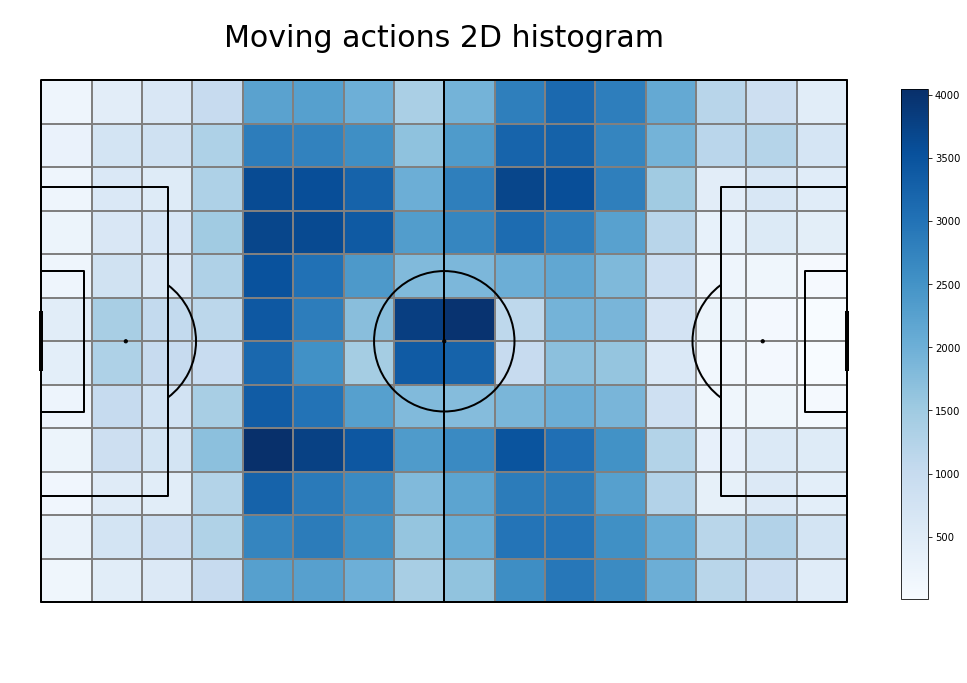

In [282]:
next_event = train.shift(-1, fill_value=0)
train["nextEvent"] = next_event["subEventName"]
train["nextPlayerId"] = next_event["playerId"]
train["nextTeamId"] = next_event["teamId"]

train["kickedOut"] = train.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

#get move_df
move_df = train.loc[train['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]

#filtering out of the field
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

#extract coordinates
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

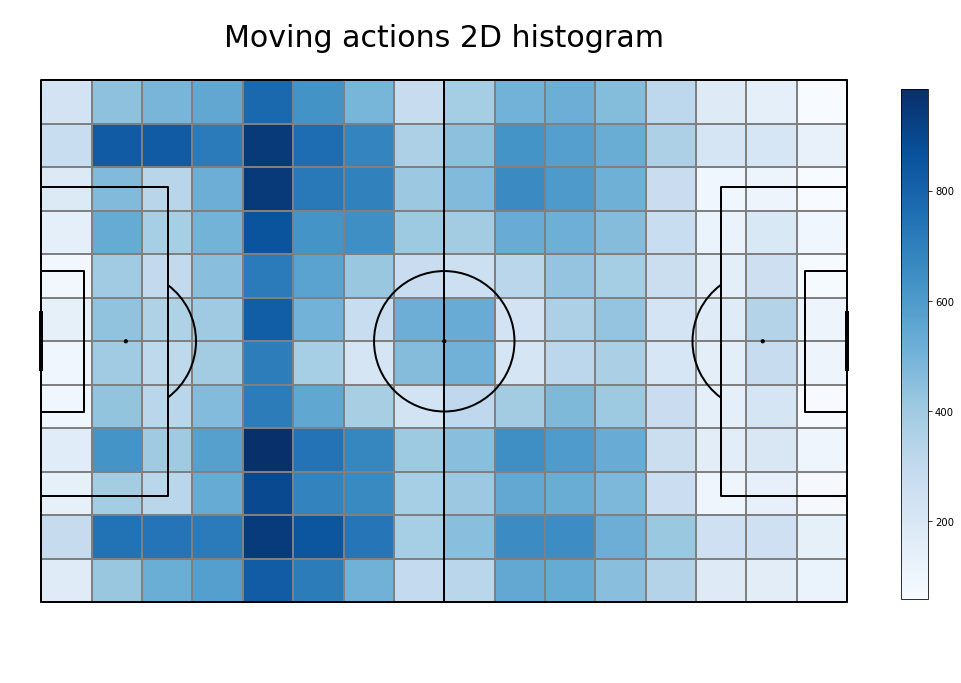

In [293]:
next_event = train.shift(-1, fill_value=0)
train["nextEvent"] = next_event["subEventName"]
train["nextPlayerId"] = next_event["playerId"]
train["nextTeamId"] = next_event["teamId"]

train["kickedOut"] = train.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

#get move_df
# move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
move_df = train.loc[train['subEventName'].isin(['Ground defending duel', 'Ground loose ball duel'])]

#filtering out of the field
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

#extract coordinates
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

# filter out actions for the middle 3rd only
# move_df = move_df.loc[(move_df["x"] < 2*105/3) & (move_df["x"] > 105/3)]

#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

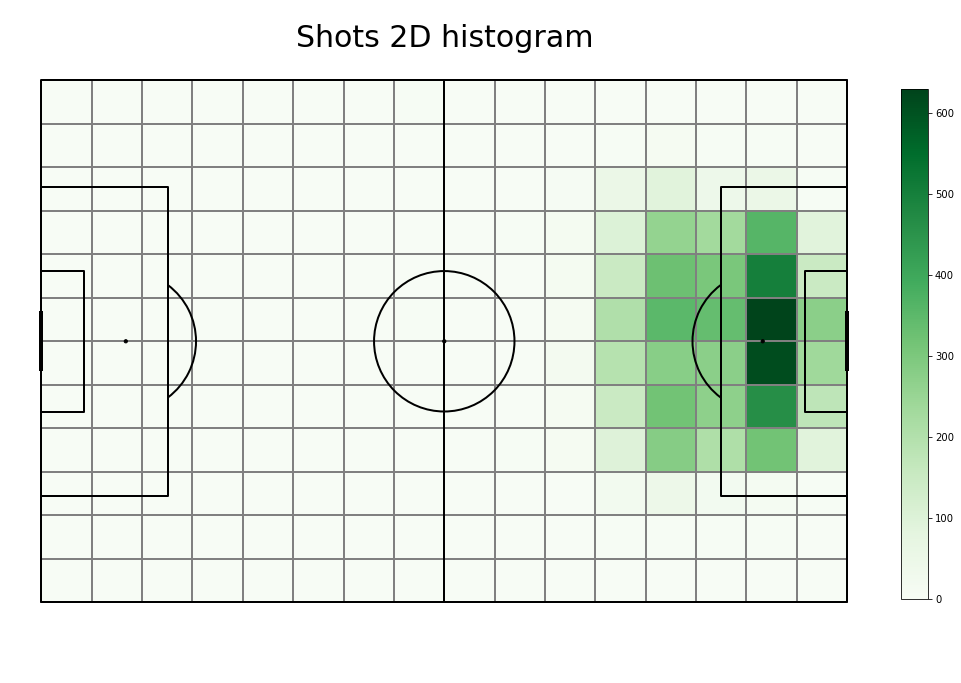

In [283]:
#get shot df
shot_df = train.loc[train['subEventName'] == "Shot"]
shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

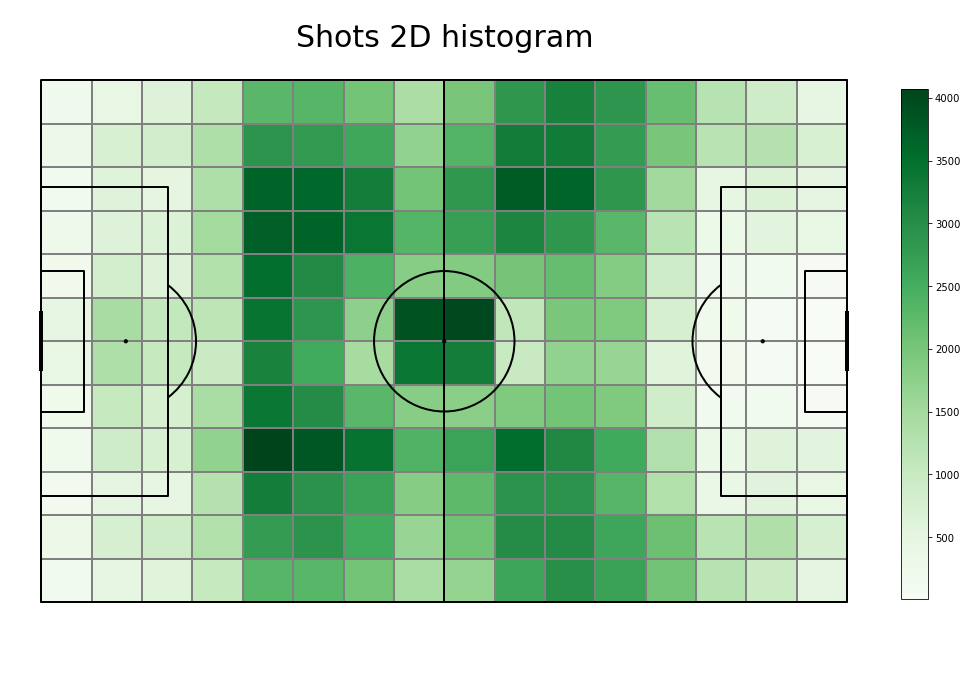

In [294]:
#get shot df
# shot_df = df.loc[df['subEventName'] == "Shot"]
shot_df = train.loc[train['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

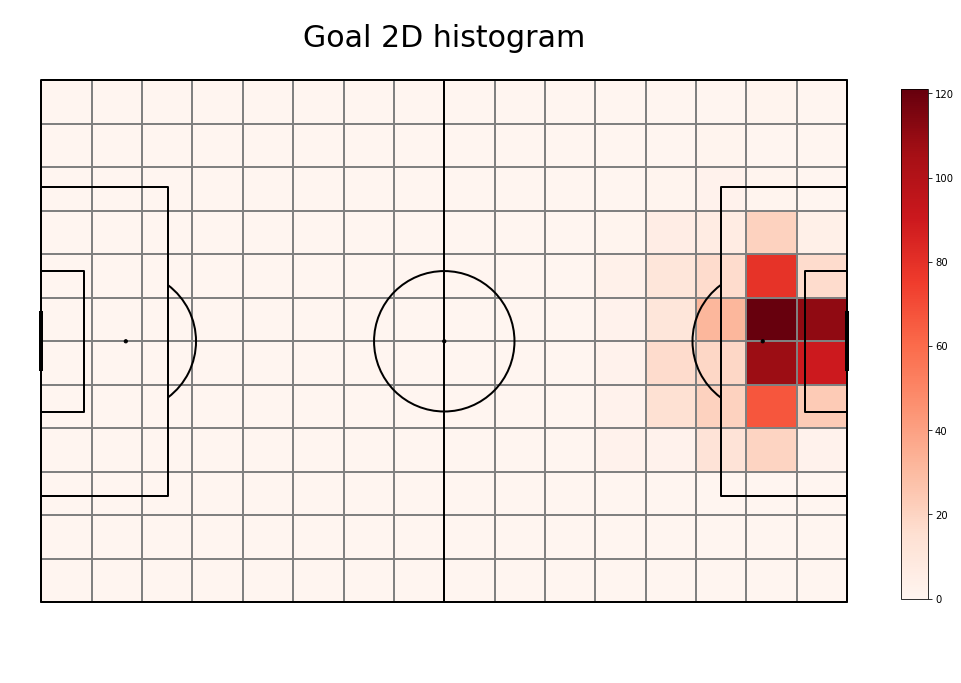

In [284]:
#get goal df
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':101} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

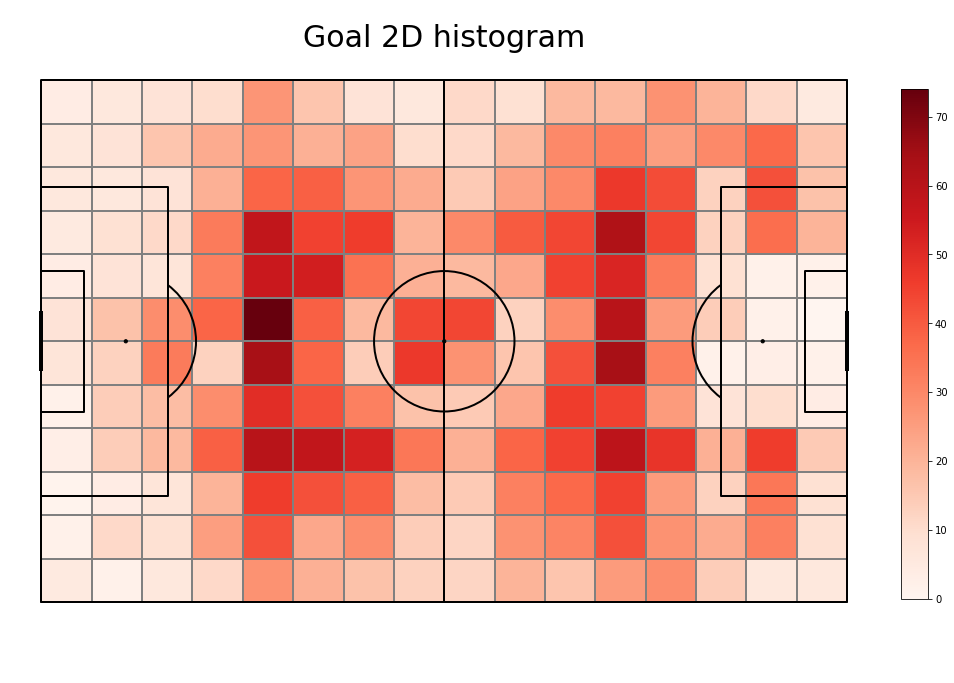

In [295]:
#get goal df
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':1901} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

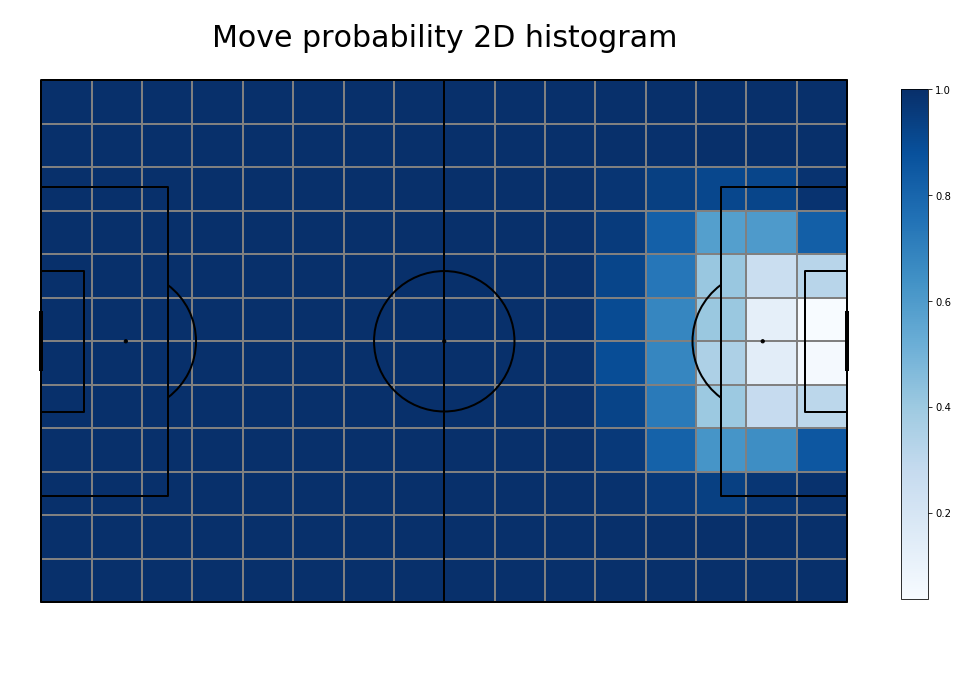

In [285]:
move_probability = move_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

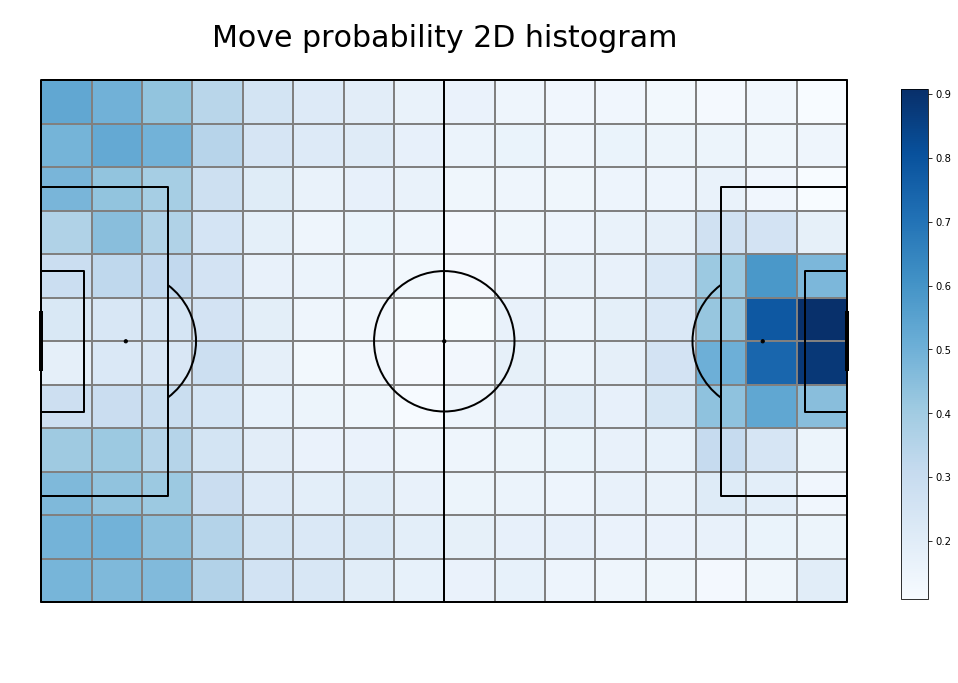

In [296]:
move_probability = move_count/(move_count+shot_count)

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

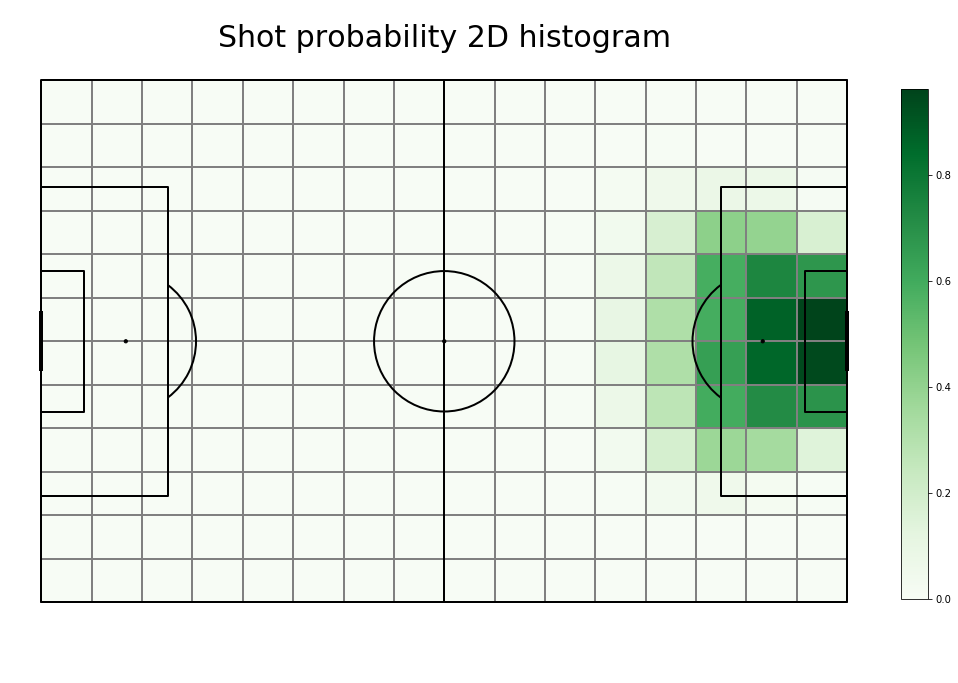

In [286]:
shot_probability = shot_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

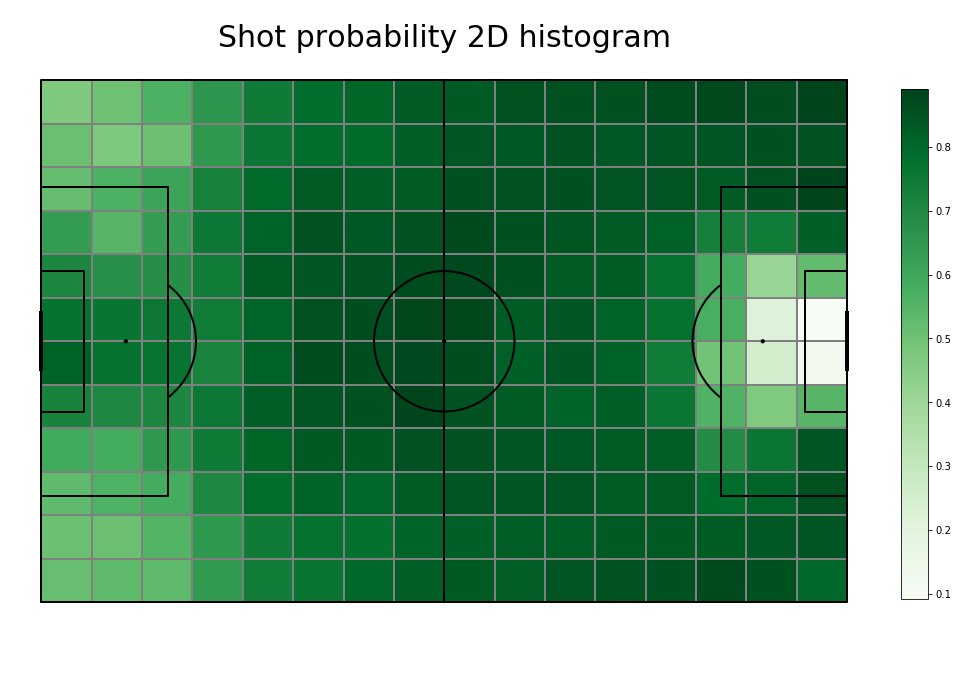

In [297]:
shot_probability = shot_count/(move_count+shot_count)

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

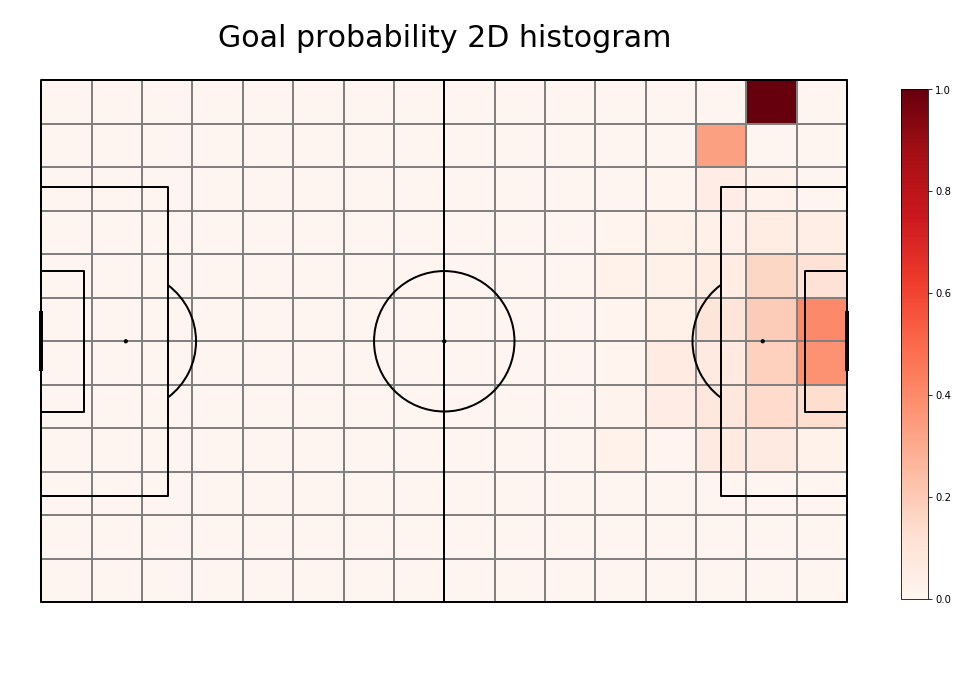

In [287]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

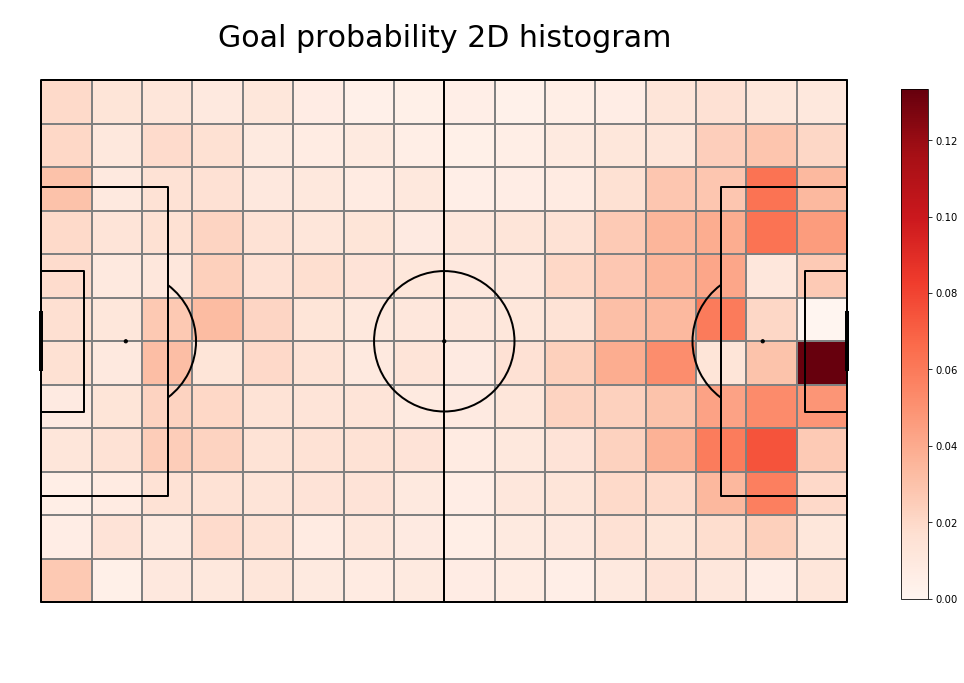

In [298]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

In [299]:
#move start index - using the same function as mplsoccer, it should work
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
#move end index
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

#df with summed events from each index
df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
df_count_starts.rename(columns = {'eventId':'count_starts'}, inplace=True)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    
    #get all events that started in this sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_cound_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    df_cound_ends.rename(columns = {'eventId':'count_ends'}, inplace=True)
    
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_cound_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

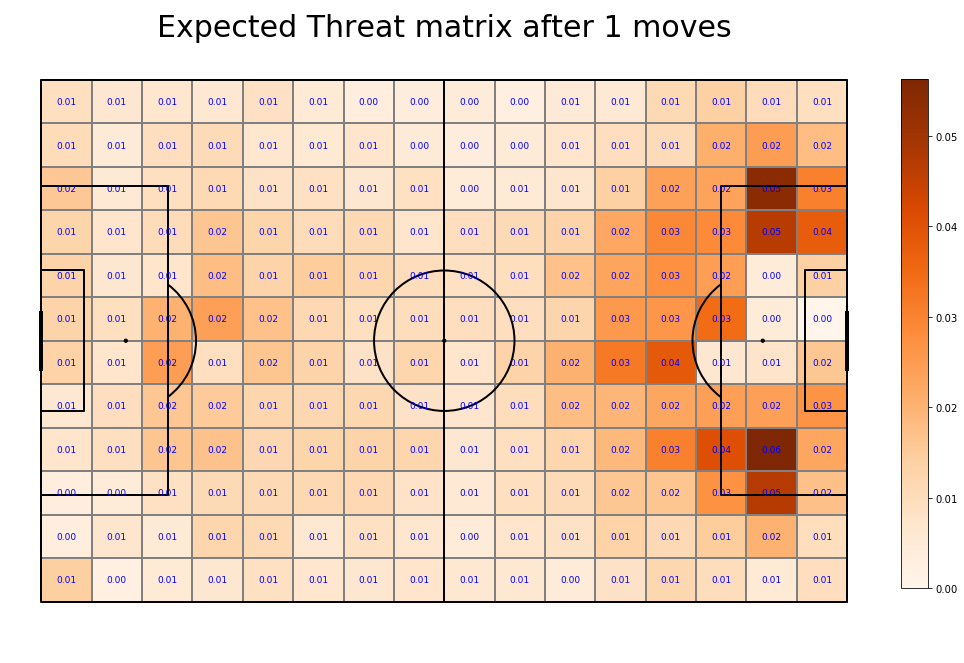

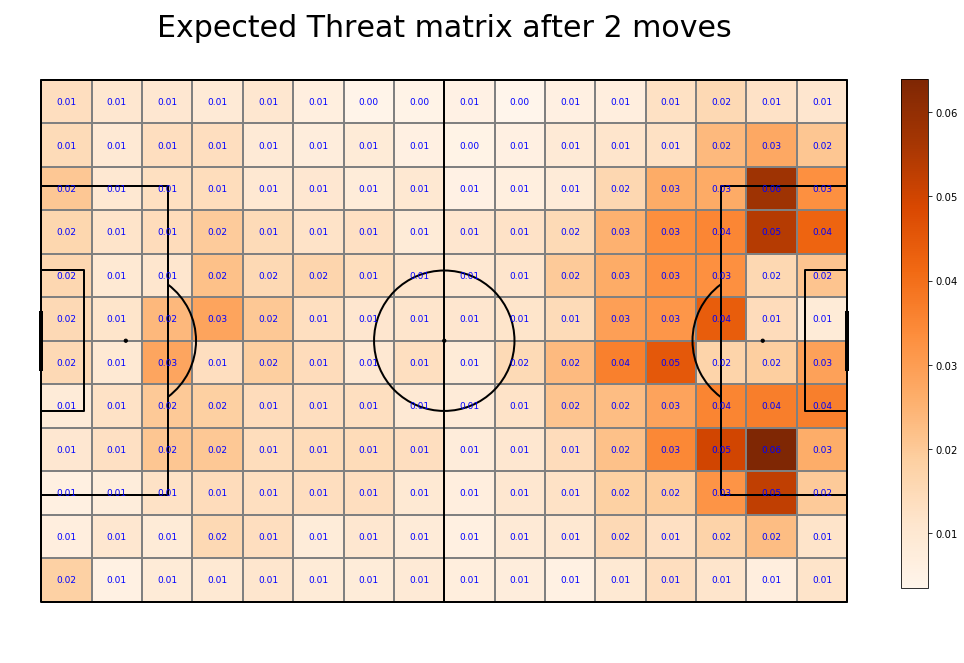

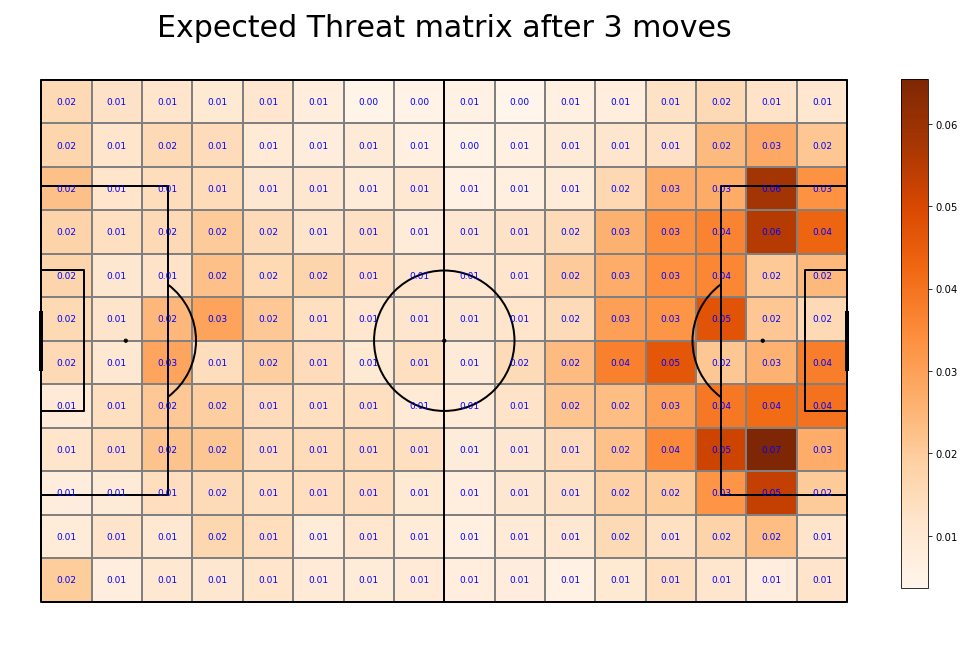

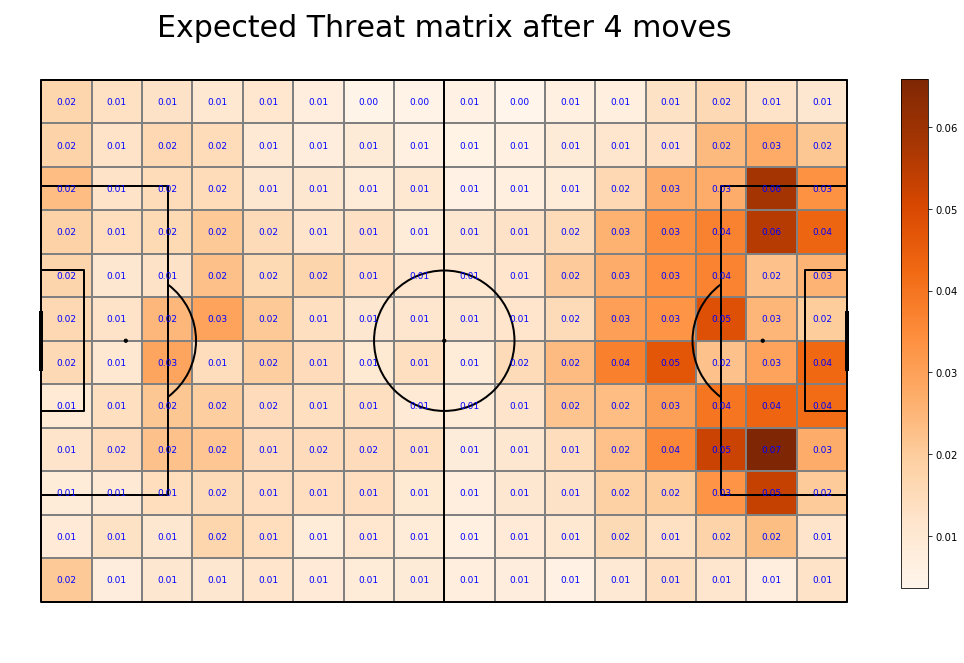

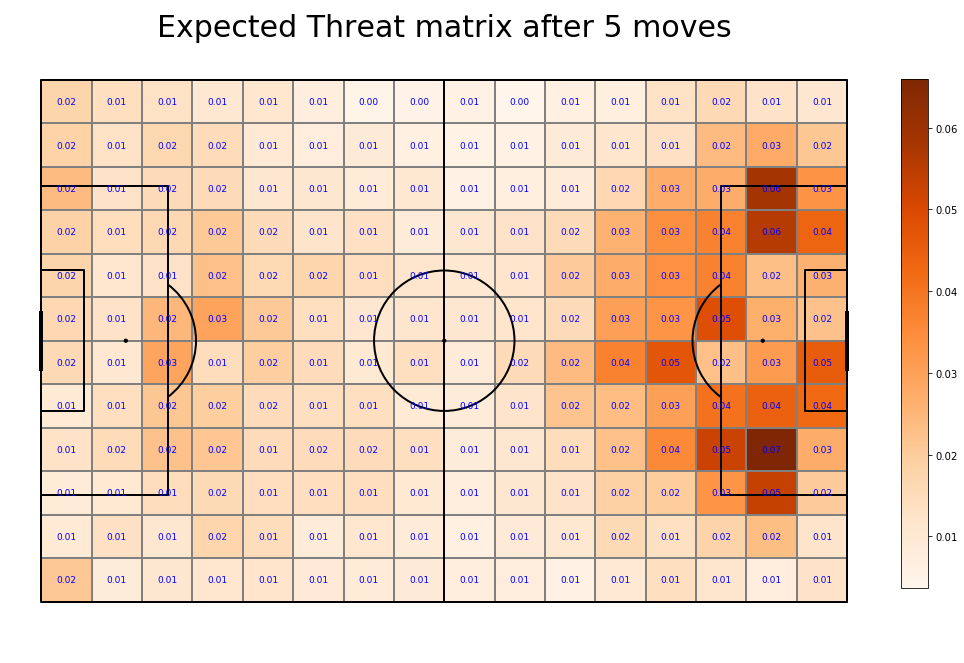

In [300]:
transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12, 16))

for i in range(5):
    shoot_expected_payoff = goal_probability*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.01, title_space=0, endnote_space=0)
    
    goal["statistic"] = xT
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

In [290]:
# intercepted middle 3rd passes
interceptions = move_df.loc[move_df.apply(lambda x:{'id':1802} in x.tags, axis = 1) & (move_df["end_x"] < 2*105/3) & (move_df["end_x"] > 105/3)]

# calculate potential xT
interceptions["xT_saved"] = interceptions.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1], axis = 1)

# only if possession changes
value_saving_actions = interceptions.loc[interceptions["teamId"] != interceptions["nextTeamId"]]

In [301]:
#only successful middle 3rd duels
successful_duels = move_df.loc[move_df.apply(lambda x:{'id':1801} in x.tags, axis = 1) & (move_df["end_x"] < 2*105/3) & (move_df["end_x"] > 105/3)]

#calculatexT
successful_duels["xT_added"] = successful_duels.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] , axis = 1)

#only progressive
value_adding_actions = successful_duels

In [291]:
#group by player
xT_saved_by_player = value_saving_actions.groupby(["nextPlayerId"])["xT_saved"].sum().reset_index()
xT_saved_by_player.rename(columns = {"nextPlayerId": "playerId"}, inplace = True)

In [302]:
#group by player
xT_added_by_player = value_adding_actions.groupby(["playerId"])["xT_added"].sum().reset_index()

In [292]:
xT_saved_by_player

,playerId,xT_saved
0,0,0.098303
1,45,0.165140
2,114,1.320219
3,122,0.312820
4,130,2.102725
...,...,...
476,447804,0.858030
477,454457,0.410414
478,481329,0.053187
479,491409,0.018730


In [303]:
xT_added_by_player

,playerId,xT_added
0,0,19.056184
1,45,0.017023
2,114,0.650640
3,122,0.323994
4,130,0.565567
...,...,...
465,454457,0.183022
466,481329,0.035236
467,485464,0.012374
468,491409,0.038942


In [338]:
train.loc[train["subEventName"].isin(["Ground defending duel", "Ground loose ball duel"])]\
        .loc[train.apply (lambda x:{'id':703} in x.tags, axis = 1)]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,nextPlayerId,nextTeamId,kickedOut
12,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",8306,"[{'y': 12, 'x': 61}, {'y': 15, 'x': 61}]",2575959,Duel,3158,1H,17.715422,13,180423967,Ground loose ball duel,246175,3172,0
47,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",8306,"[{'y': 16, 'x': 37}, {'y': 12, 'x': 40}]",2575959,Duel,3158,1H,121.083515,13,180423996,Foul,41034,3172,0
50,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",23149,"[{'y': 88, 'x': 87}, {'y': 86, 'x': 86}]",2575959,Duel,3158,1H,153.859538,13,180424004,Ground loose ball duel,295176,3172,0
63,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",21077,"[{'y': 34, 'x': 68}, {'y': 32, 'x': 70}]",2575959,Duel,3172,1H,188.486240,13,180424024,Ground loose ball duel,114,3158,0
78,1,Ground defending duel,"[{'id': 703}, {'id': 1801}]",8327,"[{'y': 30, 'x': 56}, {'y': 13, 'x': 56}]",2575959,Duel,3158,1H,217.327247,12,180424055,Ground attacking duel,280419,3172,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647243,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",14903,"[{'y': 43, 'x': 23}, {'y': 46, 'x': 30}]",2576338,Duel,3185,2H,2444.876451,13,253567040,Ground loose ball duel,70974,3193,0
647269,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",25558,"[{'y': 55, 'x': 10}, {'y': 53, 'x': 7}]",2576338,Duel,3185,2H,2538.714394,13,253567057,Ground loose ball duel,115933,3193,0
647274,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",413041,"[{'y': 22, 'x': 41}, {'y': 30, 'x': 43}]",2576338,Duel,3193,2H,2555.784789,13,253567039,Ground loose ball duel,354552,3185,0
647311,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",354552,"[{'y': 86, 'x': 71}, {'y': 92, 'x': 66}]",2576338,Duel,3185,2H,2683.548366,13,253567109,Ground loose ball duel,20749,3193,0


In [339]:
def wonDefMidDuels(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    duels_won: dataframe
        dataframe with number of won Ground loose ball duel and Ground defending duel for a player

    """
    #find ground duels won
    ground_def_duels = df.loc[df["subEventName"].isin(["Ground defending duel", "Ground loose ball duel"])]
    won_def_duels = ground_def_duels.loc[ground_def_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]
    
    #filter for middle 3rd duels
    won_def_duels["x"] = won_def_duels.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    won_def_duels["y"] = won_def_duels.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    won_def_mid_duels = won_def_duels.loc[(won_def_duels["x"] < 2*105/3) & (won_def_duels["x"] > 105/3)]
    
    #group and sum duels
    result =  won_def_mid_duels.groupby(["playerId"]).eventId.count().reset_index()
    result.rename(columns = {'eventId':'def_mid_duels_won'}, inplace=True)

    #outer join
    # def_duels_won = wgdef_player.merge(wglb_player, how = "outer", on = ["playerId"])
    return result

def_mid_duels = wonDefMidDuels(train)
#investigate structure
def_mid_duels.sort_values(by="def_mid_duels_won", ascending=False)

,playerId,def_mid_duels_won
0,0,1078
30,7965,84
247,40726,75
402,333571,70
399,302799,63
...,...,...
254,49979,1
244,37959,1
436,377757,1
431,364640,1


In [340]:
def midFouls(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    mid_fouls: dataframe
        dataframe with number of middle third fouls.

    """
    #get fouls
    fouls = df.loc[df["eventName"] == "Foul"]
    
    #filter for middle 3rd duels
    fouls["x"] = fouls.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    fouls["y"] = fouls.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    fouls = fouls.loc[(fouls["x"] < 2*105/3) & (fouls["x"] > 105/3)]

    #sum by player
    mid_fouls =  fouls.groupby(["playerId"]).eventId.count().reset_index()
    mid_fouls.rename(columns = {'eventId':'mid_fouls'}, inplace=True)

    return mid_fouls

mid_fouls = midFouls(train)
#investigate structure
mid_fouls.head()

,playerId,mid_fouls
0,0,23
1,114,25
2,122,13
3,130,11
4,174,1


In [341]:
mid_fouls.sort_values(by='mid_fouls', ascending=False)

,playerId,mid_fouls
42,14903,41
381,286223,40
7,625,36
216,22933,34
397,328336,33
...,...,...
423,368340,1
245,40806,1
373,272280,1
24,3795,1


In [342]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", "Wyscout", "minutes_played", 'minutes_played_per_game_Italy.json')
minutes_per_game = pd.read_json(path, encoding='unicode-escape')
# with open(path) as f:
#     minutes_per_game = json.load(f)
# minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
minutes.head(3)

,playerId,minutesPlayed
0,45,313
1,114,2354
2,122,3099


In [343]:
players = train["playerId"].unique()
summary = pd.DataFrame(players, columns = ["playerId"])

summary = summary.merge(def_mid_duels, how="left", on=["playerId"])\
                .merge(mid_fouls, how="left", on=["playerId"])\
                .merge(xT_saved_by_player, how="left", on=["playerId"])\
                .merge(xT_added_by_player, how="left", on=["playerId"])\
                .merge(xT_duels, how="left", on=["playerId"])
summary = minutes.merge(summary, how="left", on=["playerId"])

summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
summary.head(3)

,playerId,minutesPlayed,def_mid_duels_won,mid_fouls,xT_saved,xT_added,xT
1,114,2354,41.0,25.0,1.320219,0.650640,0.133947
2,122,3099,20.0,13.0,0.312820,0.323994,-0.396562
3,130,3144,34.0,11.0,2.102725,0.565567,0.019260


In [344]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 1 to 532
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   playerId           421 non-null    int64  
 1   minutesPlayed      421 non-null    int64  
 2   def_mid_duels_won  421 non-null    float64
 3   mid_fouls          421 non-null    float64
 4   xT_saved           421 non-null    float64
 5   xT_added           421 non-null    float64
 6   xT                 421 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 26.3 KB


In [345]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", 'Wyscout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
# with open(path) as f:
#     players = json.load(f).encode('utf8')
# player_df = pd.DataFrame(players)

In [346]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3603 entries, 0 to 3602
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   passportArea           3603 non-null   object
 1   weight                 3603 non-null   int64 
 2   firstName              3603 non-null   object
 3   middleName             3603 non-null   object
 4   lastName               3603 non-null   object
 5   currentTeamId          3512 non-null   object
 6   birthDate              3603 non-null   object
 7   height                 3603 non-null   int64 
 8   role                   3603 non-null   object
 9   birthArea              3603 non-null   object
 10  wyId                   3603 non-null   int64 
 11  foot                   3603 non-null   object
 12  shortName              3603 non-null   object
 13  currentNationalTeamId  3603 non-null   object
dtypes: int64(3), object(11)
memory usage: 394.2+ KB


In [347]:
player_df.loc[player_df.apply(lambda x: x.role["name"] == "Midfielder", axis=1)].head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
9,"{'name': 'Denmark', 'id': '208', 'alpha3code':...",76,Christian,,Dannemann Eriksen,1624,1992-02-14,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Denmark', 'id': '208', 'alpha3code':...",54,right,C. Eriksen,7712
10,"{'name': 'Austria', 'id': '40', 'alpha3code': ...",74,Marcel,,Sabitzer,2975,1994-03-17,177,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Austria', 'id': '40', 'alpha3code': ...",65596,right,M. Sabitzer,null
15,"{'name': 'Iceland', 'id': '352', 'alpha3code':...",77,Johann,,Berg Guðmunds­son,1646,1990-10-27,186,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Iceland', 'id': '352', 'alpha3code':...",93,left,J. Guðmunds­son,7839
20,"{'name': 'Netherlands', 'id': '528', 'alpha3co...",78,Kevin,,Strootman,3158,1990-02-13,186,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Netherlands', 'id': '528', 'alpha3co...",114,left,K. Strootman,null


In [348]:
midfielders = player_df.loc[player_df.apply(lambda x: x.role["name"] == "Midfielder", axis = 1)]
midfielders.rename(columns = {'wyId':'playerId'}, inplace=True)

to_merge = midfielders[['playerId', 'shortName']]
summary = summary.merge(to_merge, how="inner", on=["playerId"])
summary.head(3)

,playerId,minutesPlayed,def_mid_duels_won,mid_fouls,xT_saved,xT_added,xT,shortName
0,114,2354,41.0,25.0,1.320219,0.650640,0.133947,K. Strootman
1,174,1016,13.0,1.0,0.237020,0.281419,0.040549,F. Đuričić
2,625,2692,62.0,36.0,2.046275,0.983171,0.071037,M. de Roon


In [349]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   playerId           143 non-null    int64  
 1   minutesPlayed      143 non-null    int64  
 2   def_mid_duels_won  143 non-null    float64
 3   mid_fouls          143 non-null    float64
 4   xT_saved           143 non-null    float64
 5   xT_added           143 non-null    float64
 6   xT                 143 non-null    float64
 7   shortName          143 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 10.1+ KB


In [350]:
minutes_per_game.head(3)

,playerId,shortName,matchId,teamId,teamName,player_in_min,player_out_min,minutesPlayed,red_card
0,21384,C. Immobile,2576335,3162,SS Lazio,0,75,75,0
1,37745,J. Lukaku,2576335,3162,SS Lazio,75,94,19,0
2,20550,Ş. Radu,2576335,3162,SS Lazio,0,77,77,0


In [360]:
minutes_per_game.loc[minutes_per_game['teamName']=='SSC Napoli']['shortName'].unique()

array(['A. Milik', 'D. Mertens', 'L. Insigne', 'M. Hamšík', 'Allan',
       'M. Rog', 'E. Hysaj', 'Jorginho', 'Pepe Reina', 'P. Zieliński',
       'K. Koulibaly', 'Albiol', 'José Callejón', 'Mário Rui', 'A. Ounas',
       'V. Chiricheș', 'L. Tonelli', 'A. Diawara', 'C. Maggio',
       'N. Maksimović', 'L. Sepe', 'E. Giaccherini', 'F. Ghoulam'],
      dtype=object)

In [353]:
possession_dict = {}

#for every row in the dataframe
for i, row in minutes_per_game.iterrows():
    #take player id, team id and match id, minute in and minute out
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
    
    #create a key in dictionary if player encounterd first time
    if not str(player_id) in possession_dict.keys():
        possession_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
    min_in = row["player_in_min"]*60
    min_out = row["player_out_min"]*60

    #get the dataframe of events from the game
    match_df = train.loc[train["matchId"] == match_id].copy()
    #add to 2H the highest value of 1H
    match_df.loc[match_df["matchPeriod"]=="2H", 'eventSec'] = (match_df.loc[match_df["matchPeriod"]=="2H", 'eventSec'] 
                                                                + match_df.loc[match_df["matchPeriod"] == "1H"]["eventSec"].iloc[-1])
    #take all events from this game and this period
    player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[match_df["eventSec"] <= min_out]
    #take all passes and won duels as described
    all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(["Pass", "Duel"])]
    
    #adjusting for no passes in this period (Tuanzebe)
    if len(all_passes) > 0:
        #removing lost air duels
        no_contact = all_passes.loc[all_passes["subEventName"]\
                                    .isin(["Air duel", "Ground defending duel","Ground loose ball duel"])]\
                                        .loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
        all_passes = all_passes.drop(no_contact.index)
    
    #take team passes
    team_passes = all_passes.loc[all_passes["teamId"] == team_id]
    #append it {player id: {team passes: sum, all passes : sum}}
    possession_dict[str(player_id)]["team_passes"] += len(team_passes)
    possession_dict[str(player_id)]["all_passes"] += len(all_passes)

In [354]:
possession_dict

{'21384': {'team_passes': 18528, 'all_passes': 36049},
 '37745': {'team_passes': 9210, 'all_passes': 18139},
 '20550': {'team_passes': 17821, 'all_passes': 35494},
 '208865': {'team_passes': 9805, 'all_passes': 19418},
 '130': {'team_passes': 20648, 'all_passes': 40742},
 '7926': {'team_passes': 2845, 'all_passes': 5565},
 '346908': {'team_passes': 5545, 'all_passes': 10880},
 '376362': {'team_passes': 8054, 'all_passes': 15491},
 '166534': {'team_passes': 23539, 'all_passes': 46249},
 '20561': {'team_passes': 16407, 'all_passes': 32930},
 '40806': {'team_passes': 8040, 'all_passes': 15480},
 '265865': {'team_passes': 19310, 'all_passes': 38486},
 '228928': {'team_passes': 17290, 'all_passes': 33906},
 '7965': {'team_passes': 19775, 'all_passes': 38935},
 '20556': {'team_passes': 18669, 'all_passes': 33787},
 '20626': {'team_passes': 6322, 'all_passes': 10828},
 '3344': {'team_passes': 8303, 'all_passes': 14221},
 '352993': {'team_passes': 3999, 'all_passes': 6370},
 '21094': {'team_pa

In [355]:
#calculate possession for each player
percentage_dict = {key: value["team_passes"]/value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possession_dict.items()}

#create a dataframe
percentage_df = pd.DataFrame(percentage_dict.items(), columns = ["playerId", "possession"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)

In [54]:
# #calculate per 100 opposition touches possession for each player
# percentage_dict = {key: ((value["all_passes"]-value["team_passes"]))
#                    if (value["all_passes"]-value["team_passes"]) > 0 else 0 for key, value in possession_dict.items()}
# #create a dataframe
# percentage_df = pd.DataFrame(percentage_dict.items(), columns = ["playerId", "oppTouches"])
# percentage_df["playerId"] = percentage_df["playerId"].astype(int)

In [365]:
#merge it
summary = summary.merge(percentage_df, how="left", on=["playerId"])

In [366]:
percentage_df.head(3)

,playerId,possession
0,21384,0.513967
1,37745,0.507746
2,20550,0.502085


In [367]:
summary.head()

,playerId,minutesPlayed,def_mid_duels_won,mid_fouls,xT_saved,xT_added,xT,shortName,possession
0,114,2354,41.0,25.0,1.320219,0.650640,0.133947,K. Strootman,0.564539
1,174,1016,13.0,1.0,0.237020,0.281419,0.040549,F. Đuričić,0.504430
2,625,2692,62.0,36.0,2.046275,0.983171,0.071037,M. de Roon,0.560570
3,3318,1970,15.0,3.0,0.830393,0.234050,0.068724,S. Khedira,0.545103
4,3344,1081,20.0,6.0,0.243180,0.312118,0.145570,Rafinha,0.583855


In [398]:
summary.sort_values(by='xT_added', ascending=False)[:25]

,playerId,minutesPlayed,def_mid_duels_won,mid_fouls,xT_saved,xT_added,xT,shortName,possession
8,7965,2987,84.0,29.0,2.506005,1.520137,0.198634,Lucas Leiva,0.507898
129,302799,3380,63.0,30.0,2.919857,1.287746,0.054844,R. Mandragora,0.411222
131,333571,3305,70.0,27.0,2.983773,1.271036,0.128946,L. Torreira,0.527405
38,20815,3123,58.0,14.0,2.336110,1.179729,0.248768,A. Barberis,0.408425
83,40726,2949,75.0,23.0,1.892854,1.140536,0.417976,Allan,0.611340
57,21315,2722,55.0,17.0,2.491020,1.057794,0.101508,Jorginho,0.619131
90,69400,2445,55.0,30.0,2.305138,1.031132,0.071091,M. Badelj,0.533084
119,265865,2962,62.0,26.0,0.975092,1.009738,0.050166,S. Milinković-Savić,0.501741
2,625,2692,62.0,36.0,2.046275,0.983171,0.071037,M. de Roon,0.560570
86,49991,3136,60.0,19.0,1.904004,0.963443,0.131969,R. Freuler,0.550646


In [421]:
summary.loc[summary['shortName'].isin(['Jorginho', 'S. Milinković-Savić', 'L. Torreira', 'Lucas Leiva'])]

,playerId,minutesPlayed,def_mid_duels_won,mid_fouls,xT_saved,xT_added,xT,shortName,possession
8,7965,2987,84.0,29.0,2.506005,1.520137,0.198634,Lucas Leiva,0.507898
57,21315,2722,55.0,17.0,2.491020,1.057794,0.101508,Jorginho,0.619131
119,265865,2962,62.0,26.0,0.975092,1.009738,0.050166,S. Milinković-Savić,0.501741
131,333571,3305,70.0,27.0,2.983773,1.271036,0.128946,L. Torreira,0.527405


In [371]:
summary.columns

Index(['playerId', 'minutesPlayed', 'def_mid_duels_won', 'mid_fouls',
       'xT_saved', 'xT_added', 'xT', 'shortName', 'possession'],
      dtype='object')

In [372]:
#create a new dataframe only for it
summary_adjusted = pd.DataFrame()
summary_adjusted["shortName"] = summary["shortName"]

summary = summary[[
    'playerId', 'minutesPlayed',
    # 'npxG', 
    # "goals", 
    # "assists", "key_passes", 
    # "smart_passes_adjusted_per90",
    # "final_third_passes", "final_third_receptions",
    "def_mid_duels_won", "mid_fouls",
    "xT_saved", "xT_added", "xT",
    'shortName', 'possession'
]]
    # "ground_duels_won_adjusted_per90", "air_duels_won_adjusted_per90"]]

min_range = []
max_range = []
#calculate value adjusted
for column in summary.columns[2:7]:
    # (1000/x["oppTouches"])
    summary_adjusted[column + "_adjusted_per90"] = summary.apply(lambda x: (x[column]/x["possession"] * (90/x["minutesPlayed"])), axis = 1)
    # summary_adjusted[column + "_adjusted_per90"] = summary.apply(lambda x: (x[column] * (1000/x["oppTouches"])), axis = 1) 
    min_range.append(summary_adjusted[column + "_adjusted_per90"].min())
    max_range.append(summary_adjusted[column + "_adjusted_per90"].max())    

In [373]:
summary_adjusted.head()

,shortName,def_mid_duels_won_adjusted_per90,mid_fouls_adjusted_per90,xT_saved_adjusted_per90,xT_added_adjusted_per90,xT_adjusted_per90
0,K. Strootman,2.776682,1.693099,0.089410,0.044064,0.009071
1,F. Đuričić,2.282921,0.175609,0.041623,0.049420,0.007121
2,M. de Roon,3.697681,2.147040,0.122040,0.058636,0.004237
3,S. Khedira,1.257155,0.251431,0.069596,0.019616,0.005760
4,Rafinha,2.851950,0.855585,0.034677,0.044507,0.020758


In [420]:
summary_adjusted.loc[summary['shortName'].isin(['Jorginho', 'S. Milinković-Savić', 'L. Torreira', 'Lucas Leiva'])]

,shortName,def_mid_duels_won_adjusted_per90,mid_fouls_adjusted_per90,xT_saved_adjusted_per90,xT_added_adjusted_per90,xT_adjusted_per90
8,Lucas Leiva,4.983222,1.720398,0.148666,0.090181,0.011784
57,Jorginho,2.937207,0.907864,0.133030,0.056490,0.005421
119,S. Milinković-Savić,3.754652,1.574531,0.059050,0.061149,0.003038
131,L. Torreira,3.614302,1.394088,0.154061,0.065627,0.006658


In [443]:
#player to investigate - Kanté
#only his statistics
player_name = "L. Torreira"
# player_name = "N. Kanté"
# player_name = "Fàbregas"

player_adjusted = summary_adjusted.loc[summary_adjusted["shortName"] == player_name]

#columns similar together
# kante_adjusted = kante_adjusted[[
#     'npxG_adjusted_per90', "goals_adjusted_per90", 
#     "assists_adjusted_per90", "key_passes_adjusted_per90", 
#     # "smart_passes_adjusted_per90",
#     "final_third_passes_adjusted_per90", "final_third_receptions_adjusted_per90",
#     "def_mid_duels_won_adjusted_per90", "mid_fouls_adjusted_per90"]]
#     # "ground_duels_won_adjusted_per90", "air_duels_won_adjusted_per90"]]

#take only necessary columns - exclude playerId
adjusted_columns = player_adjusted.columns[1:8]

#values to mark on the plot
values = [round(player_adjusted[column].iloc[0],2) for column in adjusted_columns]

#percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], player_adjusted[column].iloc[0])) for column in adjusted_columns]

In [444]:
player_adjusted

,shortName,def_mid_duels_won_adjusted_per90,mid_fouls_adjusted_per90,xT_saved_adjusted_per90,xT_added_adjusted_per90,xT_adjusted_per90
131,L. Torreira,3.614302,1.394088,0.154061,0.065627,0.006658


In [445]:
values

[3.61, 1.39, 0.15, 0.07, 0.01]

In [446]:
percentiles

[85, 48, 84, 88, 65]

In [447]:
percentiles[1] = 100 - percentiles[1]

In [448]:
percentiles

[85, 52, 84, 88, 65]

In [449]:
summary_adjusted['def_mid_duels_won_adjusted_per90'].min()

0.6387873484406447

In [450]:
summary_adjusted['def_mid_duels_won_adjusted_per90'].max()

5.833002744611819

In [451]:
summary_adjusted['mid_fouls_adjusted_per90'].min()

0.10769166551301544

In [452]:
summary_adjusted['mid_fouls_adjusted_per90'].max()

4.605536595770615

In [453]:
min_range

[0.6387873484406447,
 0.10769166551301544,
 0.015456514523238797,
 0.012072930645336214,
 -0.009404018281488935]

In [433]:
max_range

[5.833002744611819,
 4.605536595770615,
 0.23824254094893255,
 0.10104829539575916,
 0.05490670272351487]

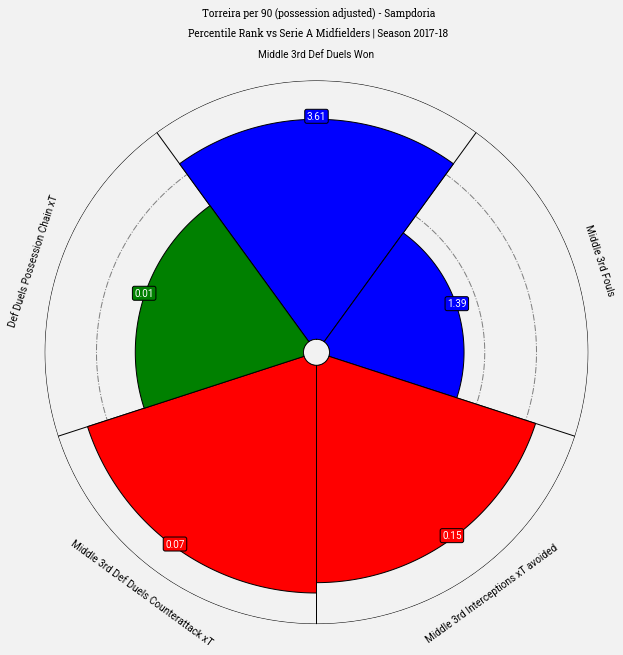

In [454]:
names = [
    # "non-penalty Expected Goals", 
    # "non-penalty Goals", 
    # "Assists", "Key Passes", 
    # "Smart Passes", 
    # "Passes Ending in Final Third", "Passes Received in Final Third", 
    "Middle 3rd Def Duels Won", "Middle 3rd Fouls",
    "Middle 3rd Interceptions xT avoided", "Middle 3rd Def Duels Counterattack xT", "Def Duels Possession Chain xT"]
    # "Offensive Ground Duels Won", "Air Duels Won"]
baker = PyPizza(
    params=names,                   # list of parameters
    # min_range=min_range,
    # max_range=max_range,
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

slice_colors = ["blue"] * 2 + ["red"] * 2 + ["green"] * 1  
text_colors = ["white"]*5
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/" "RobotoSlab%5Bwght%5D.ttf?raw=true"))
fig, ax = baker.make_pizza(
    percentiles,          # list of values: either the raw metric values or the percentile values can be chosen to plot
    figsize=(10,10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    # values to be used when plotting slices
    kwargs_slices=dict(
        facecolor="cornflowerblue", 
        edgecolor="#000000", 
        zorder=2, 
        linewidth=1),
    # values to be used when adding parameter
    kwargs_params=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        va="center"), 
    # values to be used when adding parameter-values
    kwargs_values=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        zorder=3,
        bbox=dict(
            edgecolor="#000000", 
            facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", 
            lw=1
        )
    )
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))

# add title
fig.text(
    0.515, 
    0.97, 
    "Torreira per 90 (possession adjusted) - Sampdoria", 
    size=18,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

# add subtitle
fig.text(
    0.515, 
    0.942,
    "Percentile Rank vs Serie A Midfielders | Season 2017-18",
    size=15,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

plt.show()

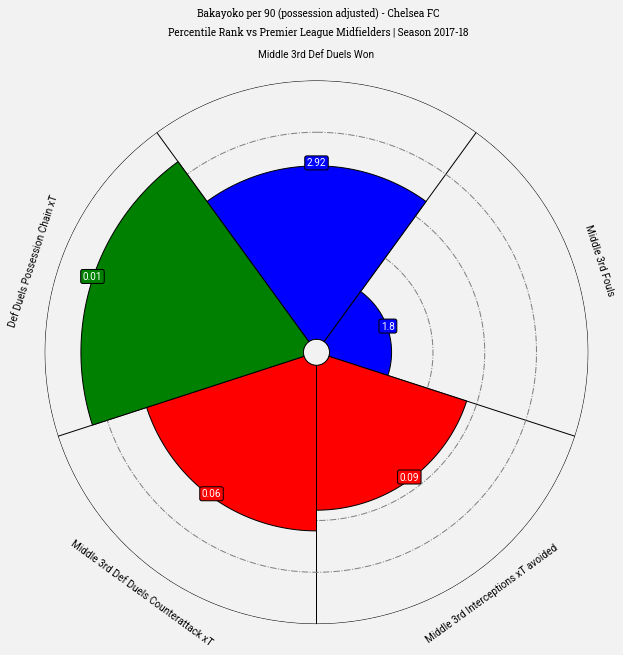

In [337]:
names = [
    # "non-penalty Expected Goals", 
    # "non-penalty Goals", 
    # "Assists", "Key Passes", 
    # "Smart Passes", 
    # "Passes Ending in Final Third", "Passes Received in Final Third", 
    "Middle 3rd Def Duels Won", "Middle 3rd Fouls",
    "Middle 3rd Interceptions xT avoided", "Middle 3rd Def Duels Counterattack xT", "Def Duels Possession Chain xT"]
    # "Offensive Ground Duels Won", "Air Duels Won"]
baker = PyPizza(
    params=names,                   # list of parameters
    # min_range=min_range,
    # max_range=max_range,
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

slice_colors = ["blue"] * 2 + ["red"] * 2 + ["green"] * 1  
text_colors = ["white"]*5
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/" "RobotoSlab%5Bwght%5D.ttf?raw=true"))
fig, ax = baker.make_pizza(
    percentiles,          # list of values: either the raw metric values or the percentile values can be chosen to plot
    figsize=(10,10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    # values to be used when plotting slices
    kwargs_slices=dict(
        facecolor="cornflowerblue", 
        edgecolor="#000000", 
        zorder=2, 
        linewidth=1),
    # values to be used when adding parameter
    kwargs_params=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        va="center"), 
    # values to be used when adding parameter-values
    kwargs_values=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        zorder=3,
        bbox=dict(
            edgecolor="#000000", 
            facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", 
            lw=1
        )
    )
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))

# add title
fig.text(
    0.515, 
    0.97, 
    "Bakayoko per 90 (possession adjusted) - Chelsea FC", 
    size=18,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

# add subtitle
fig.text(
    0.515, 
    0.942,
    "Percentile Rank vs Premier League Midfielders | Season 2017-18",
    size=15,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

plt.show()

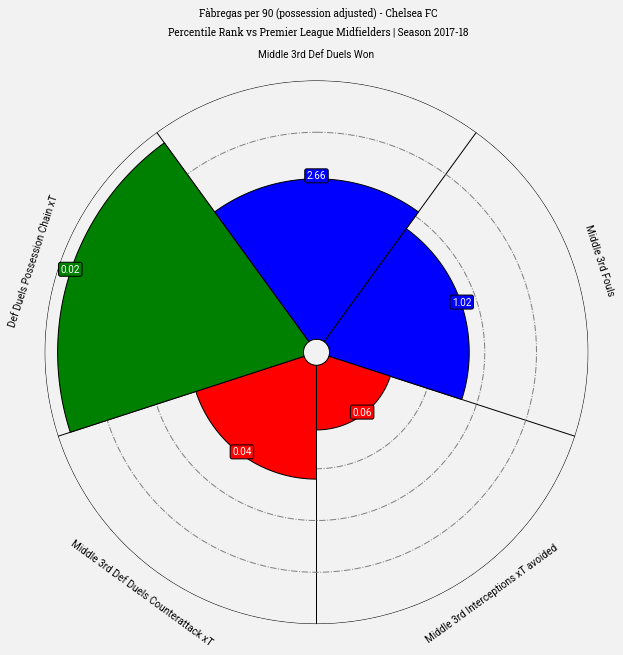

In [317]:
names = [
    # "non-penalty Expected Goals", 
    # "non-penalty Goals", 
    # "Assists", "Key Passes", 
    # "Smart Passes", 
    # "Passes Ending in Final Third", "Passes Received in Final Third", 
    "Middle 3rd Def Duels Won", "Middle 3rd Fouls",
    "Middle 3rd Interceptions xT avoided", "Middle 3rd Def Duels Counterattack xT", "Def Duels Possession Chain xT"]
    # "Offensive Ground Duels Won", "Air Duels Won"]
    # "Offensive Ground Duels Won", "Air Duels Won"]
baker = PyPizza(
    params=names,                   # list of parameters
    # min_range=min_range,
    # max_range=max_range,
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

slice_colors = ["blue"] * 2 + ["red"] * 2 + ["green"] * 1  
text_colors = ["white"]*5
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/" "RobotoSlab%5Bwght%5D.ttf?raw=true"))
fig, ax = baker.make_pizza(
    percentiles,          # list of values: either the raw metric values or the percentile values can be chosen to plot
    figsize=(10,10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    # values to be used when plotting slices
    kwargs_slices=dict(
        facecolor="cornflowerblue", 
        edgecolor="#000000", 
        zorder=2, 
        linewidth=1),
    # values to be used when adding parameter
    kwargs_params=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        va="center"), 
    # values to be used when adding parameter-values
    kwargs_values=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        zorder=3,
        bbox=dict(
            edgecolor="#000000", 
            facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", 
            lw=1
        )
    )
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))

# add title
fig.text(
    0.515, 
    0.97, 
    "Fàbregas per 90 (possession adjusted) - Chelsea FC", 
    size=18,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

# add subtitle
fig.text(
    0.515, 
    0.942,
    "Percentile Rank vs Premier League Midfielders | Season 2017-18",
    size=15,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

plt.show()